Image name (shape) (intensity max, min, mean, std)

original.png (240, 720) (210, 0, 49.3, 34.8)


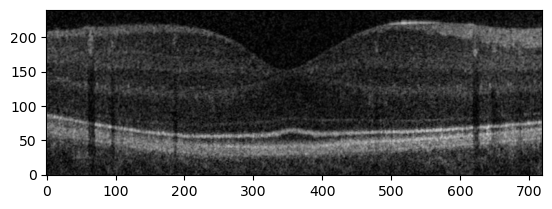

[[32 24  7 ... 53 29 38]
 [29 24 20 ... 54 51 59]
 [19 30 36 ... 52 61 70]
 ...
 [13 19 10 ... 12  9  8]
 [ 3  8 12 ...  7  4  7]
 [ 3  5 13 ... 17  7  9]]


In [1]:
import cv2
import numpy as np
import imageio.v3 as iio

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

from skimage import metrics

IMAGE='original.png'
MASK=[320, 560, 160, 880] #ymin, ymax, xmin, xmax

Path = mpath.Path
rng = np.random.default_rng()

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image('images', IMAGE, MASK)
print(image)

In [2]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))
        # self.mask = WormMask(self, image_flip)

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)
    
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

# Initialise a random clew
def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

def fft_magnitudes(values: np.ndarray):
    if len(values) < 8:
        return None

    magnitudes = np.abs(np.fft.rfft(values)[1:])
    magnitudes /= 5
    return magnitudes

In [3]:
# The worm mask class
class WormMask:
    def __init__(self, worm: Camo_Worm, image):
        self.worm = worm
        self.points = math.ceil(worm.approx_length() * 5 / worm.width)
        self.image = image
        if max(self.image[0]) > 1.0:
            self.image = self.image / 255
        self.mask = self.create_mask()

    # Create a rectangle mask around the worm    
    def create_mask(self):
        new_img = np.full(self.image.shape, 0, dtype=np.float64)
        self.max_x = 0
        self.min_x = new_img.shape[1]
        self.max_y = 0
        self.min_y = new_img.shape[0]
        pts = self.worm.intermediate_points(self.points)
        for pt in pts:
            if pt[0] < new_img.shape[1] and pt[1] < new_img.shape[0]:
                cv2.circle(new_img, (int(pt[0]), int(pt[1])), int(self.worm.width), self.worm.colour, -1)
                self.max_x = int(max(self.max_x, pt[0] + self.worm.width))
                self.max_y = int(max(self.max_y, pt[1] + self.worm.width))
                self.min_x = int(min(self.min_x, pt[0] - self.worm.width))
                self.min_y = int(min(self.min_y, pt[1] - self.worm.width))
        if self.min_x < 0: self.min_x = 0
        if self.min_y < 0: self.min_y = 0
        self.area = (self.max_x - self.min_x) * (self.max_y - self.min_y)
        return new_img[self.min_y:self.max_y, self.min_x:self.max_x]
    
    # Crop the image under the mask
    def crop_xy(self, x, y, width_x, width_y):
        return self.image[y : y + width_y, x : x + width_x].copy()
    
    # Calculate the colour difference between the mask and the image
    def colour_difference(self):
        image_crop = self.crop_xy(self.min_x, self.min_y, self.max_x - self.min_x, self.max_y - self.min_y)
        arr = []
        for i in range(0, image_crop.shape[0]):
            for j in range(0, image_crop.shape[1]):
                if self.mask[i, j] != 0:
                    arr.append(1.0 - abs(image_crop[i, j] - self.mask[i, j]))
        return np.average(arr), arr
    
    # # Caculate the FFT of the mask and the image
    # def consistence(self):
    #     image_crop = self.crop_xy(self.min_x, self.min_y, self.max_x - self.min_x, self.max_y - self.min_y)
    #     image_fft = fft_magnitudes(image_crop) if fft_magnitudes(image_crop) is not None else []
    #     return np.sum(image_fft[0:3]) / self.area

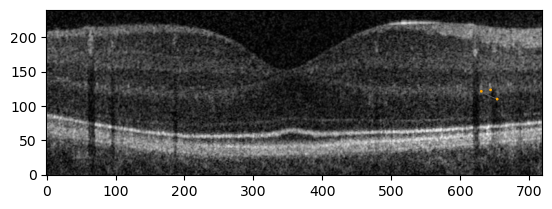

375


In [7]:
clews = initialise_clew(100, image.shape, (40, 30, 1))
worm = Camo_Worm(400, 40, 100, 0, 0, 0, 5, 0.55)
clews.append(worm)
WE = 0.5
WC = 1000
# best_worm = random_worm(image.shape, (40, 30, 1))
max_fitness = 0
max_consistent = 0
for worm in clews:
    worm_mask = WormMask(worm, image)
    env_score, dummy = worm_mask.colour_difference()
    # cons_score = worm_mask.consistence()
    if env_score * WE > max_fitness:
        max_fitness = env_score
        best_worm = worm
    # if worm_mask.consistence() > max_consistent:
    #     max_consistent = worm_mask.consistence()
    #     consistence_worm = worm

drawing = Drawing(image)
# drawing.add_worms(clews)
drawing.add_worms(best_worm)
drawing.add_dots(best_worm.intermediate_points(), radius=1, color="orange")
# drawing.add_dots(consistence_worm.intermediate_points(), radius=1, color="green")
drawing.show()
print(WormMask(best_worm, image).area)
# print(WormMask(best_worm, image).consistence() * WC)
# print(WormMask(best_worm, image).colour_difference() * WE)
# max_fitness

In [ ]:
def clamp(val, min_val, max_val):
    return min(max(val, min_val), max_val)

0.9203984216481059
0.4810323337728051


array([0.02764079, 0.04332707, 0.01941803, ..., 0.03156236, 0.06293491,
       0.0021506 ])

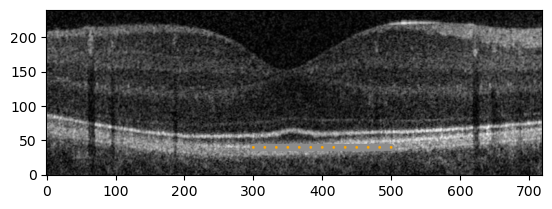

In [ ]:
# worm = Camo_Worm(400, 40, 200, 1.57, 0, 0, 1, 0.5)
worm = Camo_Worm(400, 40, 100, 0, 0, 0, 5, 0.55)
mask = WormMask(worm, image)
ft, arr = mask.colour_difference()
arr = np.array(arr)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(), radius=1, color="orange")
print(ft)
dummy_arr = np.full(arr.shape, ft, dtype=np.float64)
diff = abs(arr - dummy_arr)
# print(1 / (abs(np.sum(diff)) * 10e13))
print(abs(np.sum(diff) / worm.approx_length()))
diff